In [3]:
import numpy as np
import os
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import lightgbm as lgb
from sklearn.feature_selection import RFE, RFECV
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, auc, log_loss
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [4]:
# Acessar o patch anterior ao patch do código e acessar a pasta "data"
PATH = os.path.join(os.path.dirname(os.getcwd()), "data")

In [5]:
def load_train_test_data(path=PATH):
    train_path = os.path.join(path, "train.csv")
    test_path = os.path.join(path, "test.csv")
    return pd.read_csv(train_path), pd.read_csv(test_path)

In [6]:
train, test = load_train_test_data(PATH)

In [7]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [8]:
train.shape

(15120, 56)

In [9]:
train.isnull().sum()

Id                                    0
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int64
 1   Elevation                           15120 non-null  int64
 2   Aspect                              15120 non-null  int64
 3   Slope                               15120 non-null  int64
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 5   Vertical_Distance_To_Hydrology      15120 non-null  int64
 6   Horizontal_Distance_To_Roadways     15120 non-null  int64
 7   Hillshade_9am                       15120 non-null  int64
 8   Hillshade_Noon                      15120 non-null  int64
 9   Hillshade_3pm                       15120 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 11  Wilderness_Area1                    15120 non-null  int64
 12  Wild

In [11]:
variables = train.drop("Cover_Type", axis=1)
var_resp = train["Cover_Type"].copy()

In [12]:
x_train, x_test, y_train, y_test = train_test_split(variables, var_resp, test_size=0.2, random_state=2)

In [13]:
y_train.unique()

array([7, 1, 5, 3, 4, 2, 6], dtype=int64)

In [14]:
# Feature engineering:
# Hypotenuse_Distance_To_Hydrology - sqrt((Horizontal_Distance_To_Hydrology)^2 + (Vertical_Distance_To_Hydrology)^2) using Pythagoras's theorem
# Hillshade_Mean - (Hillshade_9am + Hillshade_Noon + Hillshade_3pm)/3
# Is_Extremely_Stony - if Type_Soil 1, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40 then 1 else 0
# Is_Very_Stony - if Type_Soil 2, 9, 18, 26 then 1 else 0
# Is_Rubbly - if Type_Soil 3, 4, 5, 10, 11, 13, 22 then 1 else 0
def add_features(data):
    data["Hypotenuse_Distance_To_Hydrology"] = np.sqrt(data["Horizontal_Distance_To_Hydrology"]**2 + data["Vertical_Distance_To_Hydrology"]**2)
    data["Hillshade_Mean"] = (data["Hillshade_9am"] + data["Hillshade_Noon"] + data["Hillshade_3pm"])/3
    data["Is_Extremely_Stony"] = np.where((data["Soil_Type1"]==1) | (data["Soil_Type24"]==1)
                                          | (data["Soil_Type25"]==1) | (data["Soil_Type27"]==1)
                                          | (data["Soil_Type28"]==1) | (data["Soil_Type29"]==1)
                                          | (data["Soil_Type30"]==1) | (data["Soil_Type31"]==1)
                                          | (data["Soil_Type32"]==1) | (data["Soil_Type33"]==1)
                                          | (data["Soil_Type34"]==1) | (data["Soil_Type36"]==1)
                                          | (data["Soil_Type37"]==1) | (data["Soil_Type38"]==1)
                                          | (data["Soil_Type39"]==1) | (data["Soil_Type40"]==1), 1, 0)
    data["Is_Very_Stony"] = np.where((data["Soil_Type2"]==1) | (data["Soil_Type9"]==1)
                                    | (data["Soil_Type18"]==1) | (data["Soil_Type26"]==1), 1, 0)
    data["Is_Rubbly"] = np.where((data["Soil_Type3"]==1) | (data["Soil_Type4"]==1)
                                    | (data["Soil_Type5"]==1) | (data["Soil_Type10"]==1)
                                    | (data["Soil_Type11"]==1) | (data["Soil_Type13"]==1)
                                    | (data["Soil_Type22"]==1), 1, 0)
    
#     https://towardsdatascience.com/predicting-forest-cover-types-with-the-machine-learning-workflow-1f6f049bf4df
    data['Mean_Elevation_Vertical_Distance_Hydrology'] = (data['Elevation'] + data['Vertical_Distance_To_Hydrology'])/2
    data['Mean_Distance_Hydrology_Firepoints'] = (data['Horizontal_Distance_To_Hydrology'] + data['Horizontal_Distance_To_Fire_Points'])/2
    data['Mean_Distance_Hydrology_Roadways'] = (data['Horizontal_Distance_To_Hydrology'] + data['Horizontal_Distance_To_Roadways'])/2
    data['Mean_Distance_Firepoints_Roadways'] = (data['Horizontal_Distance_To_Fire_Points'] + data['Horizontal_Distance_To_Roadways'])/2
    return data

In [15]:
x_train = add_features(x_train)
x_test = add_features(x_test)

<ipython-input-14-6b75c034db2c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Hypotenuse_Distance_To_Hydrology"] = np.sqrt(data["Horizontal_Distance_To_Hydrology"]**2 + data["Vertical_Distance_To_Hydrology"]**2)
<ipython-input-14-6b75c034db2c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Hillshade_Mean"] = (data["Hillshade_9am"] + data["Hillshade_Noon"] + data["Hillshade_3pm"])/3
<ipython-input-14-6b75c034db2c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [16]:
x_train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type40,Hypotenuse_Distance_To_Hydrology,Hillshade_Mean,Is_Extremely_Stony,Is_Very_Stony,Is_Rubbly,Mean_Elevation_Vertical_Distance_Hydrology,Mean_Distance_Hydrology_Firepoints,Mean_Distance_Hydrology_Roadways,Mean_Distance_Firepoints_Roadways
14492,14493,3332,6,15,467,98,2927,201,210,145,...,0,477.171877,185.333333,1,0,0,1715.0,1342.5,1697.0,2572.5
6598,6599,3257,54,13,350,42,1892,227,211,114,...,0,352.510993,184.000000,1,0,0,1649.5,1381.5,1121.0,2152.5
1554,1555,2715,68,24,0,0,120,236,186,68,...,0,0.000000,163.333333,1,0,0,1357.5,1074.0,60.0,1134.0
8237,8238,2653,129,15,418,118,1645,243,230,111,...,0,434.336275,194.666667,0,0,1,1385.5,1322.5,1031.5,1936.0
12007,12008,2775,57,20,277,129,283,230,195,90,...,0,305.565050,171.666667,1,0,0,1452.0,548.0,280.0,551.0


In [17]:
corr_with_y = pd.DataFrame(x_train.corrwith(y_train)).reset_index()
corr_with_y.columns = ["Feature", "Correlation with Cover_Type"]
corr_with_y = corr_with_y.sort_values(by="Correlation with Cover_Type", ascending=True)
corr_with_y

,Feature,Correlation with Cover_Type
11,Wilderness_Area1,-0.232345
43,Soil_Type29,-0.221039
36,Soil_Type22,-0.197892
37,Soil_Type23,-0.166764
26,Soil_Type12,-0.130803
...,...,...
54,Soil_Type40,0.204787
53,Soil_Type39,0.236540
52,Soil_Type38,0.256613
21,Soil_Type7,NaN


In [18]:
corr = x_train.loc[:, x_train.columns != 'Id'].corr()
corr.style.background_gradient(cmap='coolwarm')

D:\Programas\Anaconda3\lib\site-packages\pandas\io\formats\style.py:1264: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
D:\Programas\Anaconda3\lib\site-packages\pandas\io\formats\style.py:1265: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Hypotenuse_Distance_To_Hydrology,Hillshade_Mean,Is_Extremely_Stony,Is_Very_Stony,Is_Rubbly,Mean_Elevation_Vertical_Distance_Hydrology,Mean_Distance_Hydrology_Firepoints,Mean_Distance_Hydrology_Roadways,Mean_Distance_Firepoints_Roadways
Elevation,1.000000,-0.025962,-0.312369,0.408228,0.119204,0.578053,0.104165,0.210409,0.080820,0.447158,0.334417,0.262346,0.349230,-0.783431,-0.218561,-0.147577,-0.307899,-0.126444,-0.143234,-0.190352,nan,0.003294,-0.011814,-0.358532,-0.037473,0.019470,0.040302,-0.139301,nan,-0.070626,-0.193427,-0.035262,0.032197,0.008044,0.027273,0.143855,0.160269,0.098747,0.011864,0.019843,0.042376,0.000011,0.169528,0.046440,0.092653,0.168695,0.126205,0.019610,0.119256,0.042948,0.077863,0.325756,0.300361,0.300540,0.395797,0.228012,0.610192,-0.141783,-0.464066,0.989917,0.501652,0.615732,0.600608
Aspect,-0.025962,1.000000,0.032387,0.030152,0.052336,0.060164,-0.596826,0.324027,0.635891,-0.054175,-0.134147,0.029455,0.023637,0.087088,-0.019210,-0.023403,-0.066891,0.017867,0.001489,-0.003994,nan,0.001954,-0.021684,0.121974,-0.032517,-0.040154,0.023847,0.002730,nan,0.030078,0.032409,-0.043906,0.008609,-0.022601,0.012002,0.017943,0.040716,-0.001515,-0.002603,-0.011496,0.023071,0.028183,-0.060750,-0.089801,0.004088,-0.007206,0.017612,0.016051,-0.002012,0.003378,-0.048692,0.042698,-0.035655,0.005729,0.031828,0.357528,-0.069530,-0.040198,0.067036,-0.017792,-0.046196,0.062207,0.009645
Slope,-0.312369,0.032387,1.000000,-0.056283,0.265390,-0.273533,-0.200890,-0.609061,-0.323250,-0.240873,-0.154414,-0.065252,-0.111865,0.287283,0.102899,-0.086088,0.260109,0.085169,0.081042,-0.044582,nan,-0.014540,-0.024888,0.258239,-0.111351,-0.117227,0.121371,-0.057925,nan,-0.065771,-0.121966,-0.071326,-0.051591,-0.069197,-0.026931,-0.071751,-0.181255,0.021102,0.012365,-0.030181,0.014569,0.034603,-0.087732,0.118046,-0.073895,-0.150224,0.072605,-0.023815,-0.046951,-0.004878,0.003873,-0.153358,0.052015,-0.042185,-0.030833,-0.679991,-0.075942,-0.111117,0.365069,-0.266045,-0.240260,-0.270507,-0.299575
Horizontal_Distance_To_Hydrology,0.408228,0.030152,-0.056283,1.000000,0.656084,0.204990,-0.032850,0.080888,0.080233,0.157512,-0.016420,0.082146,0.203511,-0.234069,-0.080677,0.025402,-0.090852,-0.057463,-0.025112,0.024514,nan,0.003145,-0.006129,-0.115214,0.026513,0.039131,0.026506,-0.111534,nan,-0.088153,-0.153762,-0.017747,-0.036025,-0.064543,-0.022371,-0.012005,-0.091318,0.048086,-0.005132,0.027326,0.082598,0.025683,0.031791,-0.036492,0.061083,0.136216,0.062519,0.073218,-0.026664,0.080158,-0.010924,0.136071,0.071974,0.238860,0.998522,0.088209,0.276940,0.024684,-0.148416,0.490771,0.333524,0.348649,0.212432
Vertical_Distance_To_Hydrology,0.119204,0.052336,0.265390,0.656084,1.000000,0.011282,-0.095471,-0.128021,-0.033659,-0.014876,-0.123502,0.017479,0.070595,0.031789,-0.028719,0.007313,0.068815,-0.016069,0.019086,0.101252,nan,-0.007886,-0.016338,0.013203,-0.029040,-0.029625,0.084432,-0.087520,nan,-0.072901,-0.151517,-0.039390,-0.041766,-0.066766,-0.019443,-0.060123,-0.146633,0.015878,-0.013091,-0.016441,0.062346,0.055577,-0.061029,-0.001028,0.006100,0.019043,0.073390,0.035290,-0.031838,0.016895,-0.022994,-0.004967,0.066483,0.220340,0.692552,-0.143981,0.108161,-0.011350,0.044202,0.258642,0.105963,0.110760,-0.000667
Horizontal_Dist

In [19]:
# Aqui aplico um Pipeline para padronizar a escala nos dados numericos
# Como nao temos missings e dados categorios, nao preciso me preocupar com essa parte

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

In [20]:
# Como todas as variáveis são númericas, apenas selecionamos todas as vars
num_attribs = x_train.columns.tolist()

In [21]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs)
    ])

In [22]:
train_prepared = full_pipeline.fit_transform(x_train)

In [23]:
train_prepared

array([[ 1.59787741,  1.39829724, -1.3708379 , ...,  0.81920754,
         1.04856178,  0.91440987],
       [-0.21650888,  1.21842893, -0.9333866 , ...,  0.88693614,
         0.21648572,  0.51336412],
       [-1.37584059, -0.08141936, -0.80579664, ...,  0.35292218,
        -1.31620994, -0.45917181],
       ...,
       [-0.20754498,  1.65251111,  1.41791413, ...,  0.30950641,
         1.08395391,  0.85902736],
       [-1.14117015, -1.69783586, -0.86959162, ..., -0.9495509 ,
        -0.85611233, -0.87119857],
       [-0.04688422, -0.40758055,  0.23315019, ..., -0.07949888,
        -0.54408381, -0.45869437]])

In [24]:
train_prepared.shape

(12096, 64)

In [25]:
test_prepared = full_pipeline.transform(x_test)

In [26]:
test_prepared

array([[ 1.07659186,  0.01211216, -0.20430111, ..., -1.05635369,
        -0.88428157, -1.1156455 ],
       [-1.60453508,  0.24474184, -0.45036746, ...,  1.22818409,
         0.66285986,  0.89292527],
       [ 0.73435457, -0.63781198, -0.15873326, ..., -0.81062044,
        -0.95795497, -0.8621273 ],
       ...,
       [-0.31672074, -0.77211365, -0.97895445, ...,  0.00385939,
        -0.67048425, -0.57375631],
       [ 1.17473513, -1.73141128, -0.86959162, ..., -1.0624319 ,
        -1.20931128, -1.16673109],
       [-1.41031714,  1.14648161,  1.56373122, ...,  0.26522233,
         2.96840395,  2.08890098]])

## Melhorando o desempenho com gridsearch e cross validation

In [28]:
param_grid = [
    {
        'reduce_dim__n_components': [0.7, 0.9],
        'classify__learning_rate': [0.0001, 0.001, 0.01, 0.1],
        'classify__n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 4)],
        'classify__num_leaves': [5, 10, 20, 30, 50],
        'classify__num_iterations': [10, 50, 100, 500],
        'classify__min_data_in_leaf': [30, 50, 100],
    }
]

grid_search = GridSearchCV(
    Pipeline([
        ('reduce_dim', PCA(svd_solver='full')),
        ('classify', lgb.LGBMClassifier(
            objective = 'multiclass',
            n_jobs = -1,
            num_class = 7,
            max_depth = -1,
            boosting_type = 'gbdt',
            metric = 'multi_logloss'))
    ]), param_grid, cv=5, scoring='f1_macro', verbose=1, return_train_score=True, n_jobs=-1)
grid_search = grid_search.fit(train_prepared, y_train)

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


KeyboardInterrupt: 

In [2]:
grid_search.best_params_

NameError: name 'grid_search' is not defined

In [25]:
grid_search.best_estimator_.score(test_prepared, y_test)

0.8875661375661376

In [26]:
model = grid_search.best_estimator_

In [27]:
y_train_estimation = model.predict(train_prepared)
y_test_estimation = model.predict(test_prepared)

y_train_score = model.predict_proba(train_prepared)[:,1]
y_test_score = model.predict_proba(test_prepared)[:,1]

In [28]:
train_report = classification_report(y_train, y_train_estimation, digits=4)
print("Train:\n",train_report)

test_report = classification_report(y_test, y_test_estimation, digits=4)
print("Test:\n",test_report)

Train:
               precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000      1723
           2     1.0000    1.0000    1.0000      1741
           3     1.0000    1.0000    1.0000      1740
           4     1.0000    1.0000    1.0000      1734
           5     1.0000    1.0000    1.0000      1708
           6     1.0000    1.0000    1.0000      1721
           7     1.0000    1.0000    1.0000      1729

    accuracy                         1.0000     12096
   macro avg     1.0000    1.0000    1.0000     12096
weighted avg     1.0000    1.0000    1.0000     12096

Test:
               precision    recall  f1-score   support

           1     0.8209    0.8078    0.8143       437
           2     0.8114    0.7494    0.7792       419
           3     0.8695    0.8881    0.8787       420
           4     0.9344    0.9695    0.9516       426
           5     0.9232    0.9314    0.9273       452
           6     0.8984    0.8861    0.8922       439
         

In [29]:
y_predicted = grid_search.predict_proba(test_prepared)

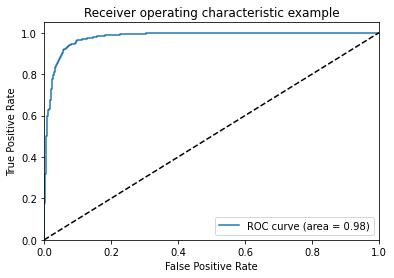

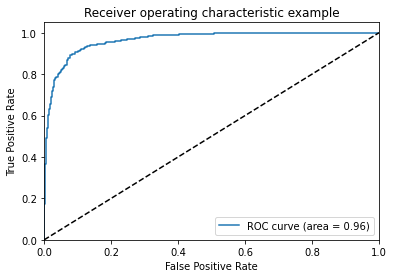

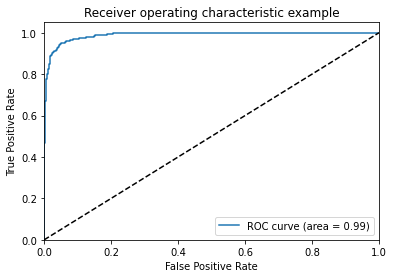

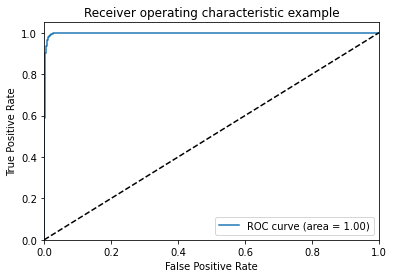

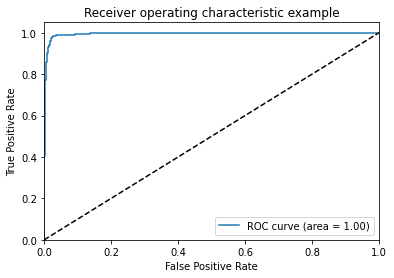

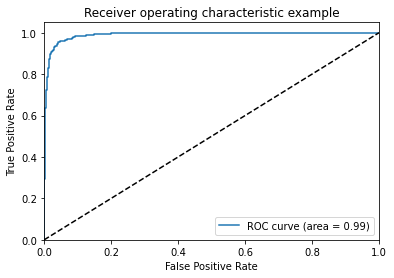

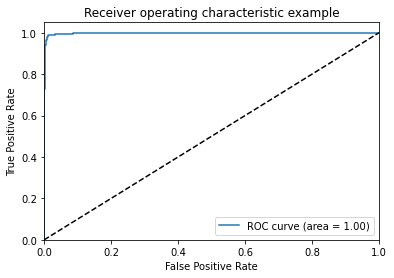

In [30]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
for i in range(len(y_test.unique())):
    fpr[i], tpr[i], thresholds = roc_curve(y_test_dummies[:, i], y_predicted[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(len(y_test.unique())):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [31]:
test = add_features(test)

In [32]:
final_test = full_pipeline.transform(test)

In [33]:
final_test

array([[ 1.74221926e+00, -1.65357898e-01,  1.80068401e+00, ...,
         4.25773647e+00,  5.35737126e-01,  2.91199963e+00],
       [ 1.74244910e+00, -1.58163165e-01, -1.42551931e+00, ...,
         4.28378593e+00,  5.14068478e-01,  2.91199963e+00],
       [ 1.74267895e+00, -8.62158433e-02, -1.27970221e+00, ...,
         3.99637354e+00,  7.49534447e-01,  2.90961245e+00],
       ...,
       [ 1.31808250e+02, -8.70441654e-01,  2.35381118e-02, ...,
        -7.18579006e-01, -1.29454130e+00, -1.09129629e+00],
       [ 1.31808480e+02, -8.75238142e-01,  1.23787368e-01, ...,
        -7.09895852e-01, -1.29454130e+00, -1.08652194e+00],
       [ 1.31808709e+02, -8.77636386e-01,  7.82195241e-02, ...,
        -7.00344383e-01, -1.31115393e+00, -1.09225116e+00]])

In [34]:
final_test.shape

(565892, 64)

In [35]:
y_predicted_test = grid_search.predict(final_test)

In [36]:
y_predicted_test.shape

(565892,)

In [37]:
y_predicted_test

array([3, 3, 2, ..., 3, 3, 3], dtype=int64)

In [38]:
test_ID = test['Id'].copy()

In [39]:
dataset = pd.DataFrame({'Id': test_ID, 'Cover_Type': y_predicted_test})

In [40]:
dataset.head()

,Id,Cover_Type
0,15121,3
1,15122,3
2,15123,2
3,15124,2
4,15125,2


In [42]:
dataset.to_csv(os.path.join(PATH, "LightGBM_output.csv"), sep=",", index=False)